# COVID-19 Dataset
Kaggle Links: [US Vaccine Tracker + Population Stats](https://www.kaggle.com/peretzcohen/us-vaccine-tracker/data#Your-turn_)

Using 2019 population data from the U.S. Census and COVID-19 vaccine records to visualize vaccine progression and predict reopening. 
***

*import necessary modules*

In [178]:
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')

***
__Extract__

In [179]:
cwd = os.getcwd()
pop_data = pd.read_csv(cwd + "\\data\\" + "2019_Census_US_Population_Data_By_State_Lat_Long.csv")
vacc_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv")

***
__Transform__

Combine population by state and total vaccinations by state

In [180]:
vacc_data_state = vacc_data[['date', 'location', 'people_vaccinated']].copy()
pop_data_state = pop_data[['STATE', 'POPESTIMATE2019']].copy()

vacc_data_state.dropna(subset=['people_vaccinated'], inplace=True)
pop_data_state.dropna(subset=['POPESTIMATE2019'], inplace=True)

pop_data_state.rename(columns={'STATE': 'location'}, inplace=True)
pop_data_state.rename(columns={'POPESTIMATE2019': 'population'}, inplace=True)

merged = pd.merge(vacc_data_state, pop_data_state, how='left', on=['location'])
merged.dropna(subset=['population'], inplace=True)

merged['location'] = merged['location'].astype(str)
merged['percent'] = merged.people_vaccinated / merged.population * 100

merged.columns = merged.columns.str.strip()
merged.date = pd.to_datetime(merged.date, format='%Y-%m-%d')

***
__Visualizations__

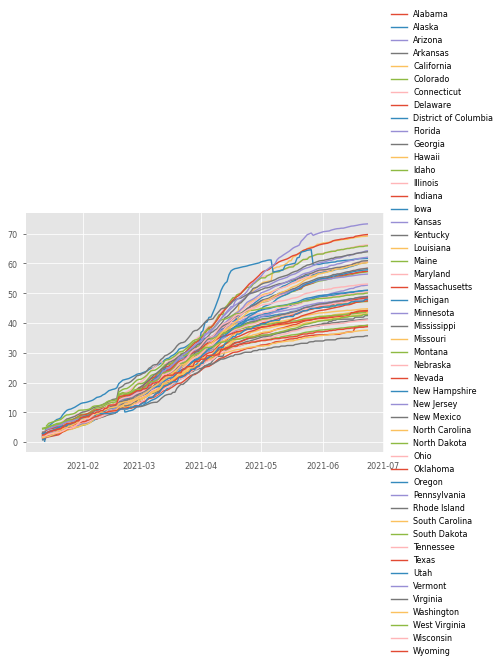

In [181]:
vis = merged[['date', 'percent', 'location']]
#vis.plot(kind='scatter', x='date', y='percent')

# limiting vis data to a single state
#vis = vis.loc[vis['location'] == 'Alabama']
#vis = vis[['date', 'percent']]
#vis.plot(kind='line', x='date', y='percent', label='Alabama')

groups = vis.groupby('location')
for name, group in groups:
    plt.plot(group['date'], group['percent'], label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

***
__Predictions__

In [186]:
# time series prediction 
from sklearn.linear_model import LinearRegression

# pulling data from one state at a time
# change the <state_name> variable to choose a location
# be sure to re-run both this cell and the following cell to update visualizations and forecast models
state_name = 'Colorado'

state = merged.loc[merged['location'] == state_name]
state = state[['location', 'date', 'percent']]

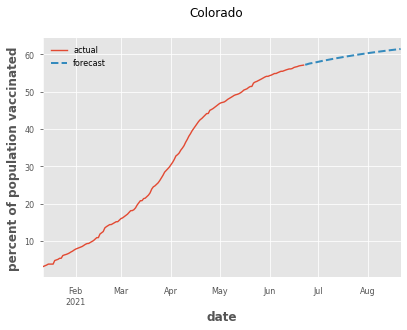

In [187]:
from darts import TimeSeries
import darts.models as models
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

get_data = state[['date', 'percent']].copy()

# fill missing dates with padded vaccination percent data. 0.0 values would otherwise disrupt the model
reset = pd.date_range(start=get_data.date.min(), end=get_data.date.max())
get_data = get_data.set_index('date').reindex(reset).fillna(method='pad').rename_axis('date').reset_index()

series = TimeSeries.from_dataframe(get_data, 'date', 'percent')
# get_data.date.max() provides the full dataset for training;
# testing is less valuable here than understanding the full picture of the data
train, test = series.split_before(pd.Timestamp(get_data.date.max()))

model = models.ARIMA()
model.fit(train)

#predict next 60 days of vaccinations
pred = model.predict(60)

train.plot(label='actual')
pred.plot(label='forecast', lw=2, linestyle='dashed')

plt.suptitle(state.location.iloc[0])
plt.ylabel('percent of population vaccinated')
plt.legend()